# Tool Selection Benchmark with 2 LLMs (Gemini Flash and Pro)

This notebook demonstrates how to benchmark the tool-calling capabilities of Google's Gemini models (gemini-2.5-flash and gemini-2.5-pro) using the Arize Phoenix evaluation framework and LlamaIndex Evaluator. Reliable tool selection is critical for agentic workflows, requiring models to not only choose the correct function but also correctly populate its arguments. We employ a hybrid evaluation strategy—combining deterministic assertions with "LLM-as-a-Judge"—to assess performance across tool naming, argument keys, and argument values.

NOTE:

* We do not benchmark the execution of the Tools
* The Galileo dataset from HuggingFace is used.  "galileo-ai/agent-leaderboard"

**Prerequisites:**
* Arize Phoenix running locally
* Google Gemini API Key
* Ollama running locally (for Llama 3.2) (this has been commented out and any user can uncomment for a local Ollama experiment)


** Thanks:**

Thanks to the People behind the Galileo.ai dataset:

* agent-leaderboard,
* author = {Pratik Bhavsar},
* title = {Agent Leaderboard},
    year = {2025},
    publisher = {Galileo.ai},
    howpublished = "\url{https://huggingface.co/datasets/galileo-ai/agent-leaderboard}"
}

In [ ]:
# Optional: Install dependencies if missing
%%capture
%pip install llama-index
%pip install llama-index-callbacks-arize-phoenix

In [ ]:
# Capture to remove Google colab error message about "google-adk 1.21.0 requires opentelemetry-api<=1.37.0,>=1.37.0, but you have opentelemetry-api 1.39.1 which is incompatible."
# Does not impact this Notebook
%%capture


%pip install -q arize-phoenix pandas datasets python-dotenv

In [ ]:
%pip install nest_asyncio llama-index-llms-ollama llama-index-llms-google-genai

In [ ]:
import os
import json
import re
from typing import Any, Dict

import nest_asyncio
import pandas as pd
import datasets
from dotenv import load_dotenv

# Arize Phoenix
import phoenix as px
from phoenix.experiments import run_experiment

# LlamaIndex Core
from llama_index.core import Settings, set_global_handler
from llama_index.core.agent import ReActAgent
from llama_index.core.tools import FunctionTool

# LlamaIndex Models
from llama_index.llms.ollama import Ollama
from llama_index.llms.google_genai import GoogleGenAI

# Apply nest_asyncio for Jupyter/Script async compatibility
nest_asyncio.apply()

### Configuration & Initialization

In [ ]:
# Uncomment if your key is in.env
# A. Environment & Keys
# load_dotenv()
# google_api_key = os.getenv("GEMINI_API_KEY")
# if not google_api_key:
#    print("⚠️ WARNING: GEMINI_API_KEY not found in environment.")


# Using Google Colab for key storage:
from google.colab import userdata

# comment the following out if using load_dotenv
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
HF_TOKEN = userdata.get("HF_TOKEN")


# B. Global Settings
Settings.chunk_size = 512

# C. Judge Model (The "Teacher")
# Using Gemini 2.0 Flash Exp for fast, accurate judging
os.environ["GOOGLE_API_KEY"] = GEMINI_API_KEY
judge_llm = GoogleGenAI(model="models/gemini-2.0-flash-exp", temperature=0.0)

In [ ]:
# D. Launch Phoenix
session = px.launch_app()

In [ ]:
# [CRITICAL] Enable LlamaIndex Trace Logging
# This hooks into the Agent internals and sends traces to Phoenix
set_global_handler("arize_phoenix")

print(f"✅ Phoenix UI: {session.url}")

### Define Evaluators (The Hybrid:  Assertion + LLM as a Judge)

*   Evaluator for Tool Name
*   Evaluator for Argument Names
*   Evaluator for Argument Values



Evaluation
To ensure a robust assessment, we utilize a hybrid evaluation approach with three specific metrics. eval_tool_name checks if the model selected the correct function. eval_tool_args_keys verifies that the generated argument structure contains the expected parameters. Finally, eval_tool_args_values assesses the accuracy of the values passed to those parameters. While tool name and keys are often evaluated deterministically, argument values can be evaluated semantically (using an LLM judge) to account for minor formatting variations that are still functionally correct.


In [ ]:
async def eval_tool_name(output: Any, reference: Dict[str, Any]) -> float:
    """
    EVALUATOR 1 (Gatekeeper): Checks if the predicted tool name matches exactly.
    Returns 1.0 (Pass) or 0.0 (Fail).
    """
    try:
        # 1. Parse Output
        raw = output.get("output") if isinstance(output, dict) else output
        if isinstance(raw, str):
            clean = raw.strip().strip("`").replace("json\n", "").strip()
            pred = json.loads(clean)
        else:
            pred = raw

        actual_name = (
            pred[0].get("name")
            if isinstance(pred, list) and pred
            else pred.get("name")
        )

        # 2. Parse Reference
        ref_raw = reference.get("answers", [])
        if isinstance(ref_raw, str):
            ref_raw = json.loads(ref_raw)
        expected_name = (
            ref_raw[0].get("name")
            if isinstance(ref_raw, list) and ref_raw
            else ref_raw.get("name")
        )

        # 3. Assertion
        return 1.0 if actual_name == expected_name else 0.0

    except Exception:
        return 0.0


async def eval_tool_args_keys(output: Any, reference: Dict[str, Any]) -> float:
    """
    EVALUATOR 2 (Structure): Checks if argument KEYS match exactly (No missing, no extras).
    Prerequisite: Tool Name must be correct (Gatekeeper).
    Returns 1.0 (Pass) or 0.0 (Fail).
    """
    try:
        # 1. Parse Output
        raw = output.get("output") if isinstance(output, dict) else output
        if isinstance(raw, str):
            clean = raw.strip().strip("`").replace("json\n", "").strip()
            pred = json.loads(clean)
        else:
            pred = raw

        actual_tool = pred[0] if isinstance(pred, list) and pred else pred
        actual_name = actual_tool.get("name")

        # Flatten kwargs if present
        a_args = actual_tool.get("arguments", actual_tool.get("kwargs", {}))
        if "kwargs" in a_args and len(a_args) == 1:
            a_args = a_args["kwargs"]
        actual_keys = set(a_args.keys())

        # 2. Parse Reference
        ref_raw = reference.get("answers", [])
        if isinstance(ref_raw, str):
            ref_raw = json.loads(ref_raw)

        expected_tool = (
            ref_raw[0] if isinstance(ref_raw, list) and ref_raw else ref_raw
        )
        expected_name = expected_tool.get("name")

        e_args = expected_tool.get(
            "arguments", expected_tool.get("kwargs", {})
        )
        if "kwargs" in e_args and len(e_args) == 1:
            e_args = e_args["kwargs"]
        expected_keys = set(e_args.keys())

        # 3. Gatekeeper Check
        if actual_name != expected_name:
            return 0.0

        # 4. Key Check
        return 1.0 if actual_keys == expected_keys else 0.0

    except Exception:
        return 0.0


async def eval_tool_args_values(
    output: Any, reference: Dict[str, Any]
) -> float:
    """
    EVALUATOR 3 (Content): Uses LLM to judge if argument VALUES are semantically correct.
    Prerequisite: Name and Keys must be correct.
    Returns 0.0 to 1.0.
    """
    try:
        # 1. Parse & Prep
        raw = output.get("output") if isinstance(output, dict) else output
        if isinstance(raw, str):
            clean = raw.strip().strip("`").replace("json\n", "").strip()
            pred = json.loads(clean)
        else:
            pred = raw

        actual_tool = pred[0] if isinstance(pred, list) and pred else pred
        actual_name = actual_tool.get("name")
        a_args = actual_tool.get("arguments", actual_tool.get("kwargs", {}))
        if "kwargs" in a_args:
            a_args = a_args["kwargs"]

        ref_raw = reference.get("answers", [])
        if isinstance(ref_raw, str):
            ref_raw = json.loads(ref_raw)
        expected_tool = (
            ref_raw[0] if isinstance(ref_raw, list) and ref_raw else ref_raw
        )
        expected_name = expected_tool.get("name")
        e_args = expected_tool.get(
            "arguments", expected_tool.get("kwargs", {})
        )
        if "kwargs" in e_args:
            e_args = e_args["kwargs"]

        # 2. Gatekeepers
        if actual_name != expected_name:
            return 0.0
        if set(a_args.keys()) != set(e_args.keys()):
            return 0.0

        # 3. LLM Judge
        prompt = f"""
        Compare the ACTUAL arguments against the EXPECTED arguments.
        Determine if the values are semantically equivalent.
        - Allow for different date formats or slight spelling variations if intent is clear.
        - Strict on numbers/booleans.

        Expected: {json.dumps(e_args)}
        Actual:   {json.dumps(a_args)}

        Return ONLY a single float number between 0.0 and 1.0.
        """
        response = await judge_llm.acomplete(prompt)

        # Extract float from response
        match = re.search(r"(\d+(\.\d+)?)", str(response.text))
        return float(match.group(1)) if match else 0.0

    except Exception as e:
        return 0.0

###  Agent Task Definition

The core task involves a "Tool Selection" challenge where the LLM is presented with a user query and a set of defined tools (functions). The model must interpret the query, identify the most appropriate tool from the available list, and generate the correct JSON-structured arguments (keys and values) required to execute that tool.

In [ ]:
async def run_mcp_agent_task(input_data):
    """
    The core logic: Takes a dataset row, builds a fresh agent, and returns the tool call.
    """
    # Parse Input
    chat_history = json.loads(input_data["conversation"])
    available_tools = json.loads(input_data["tools"])
    user_query = chat_history[-1]["content"]

    llamaindex_tools = []

    # Dynamic Tool Creation
    for tool_dict in available_tools:
        tool_name = tool_dict.get("name", "unknown")
        tool_desc = tool_dict.get("description", "")
        tool_params = json.dumps(tool_dict.get("parameters", {}))

        # Schema Injection Strategy
        enriched_desc = (
            f"{tool_desc}\n\n"
            f"INSTRUCTION: Output arguments matching these parameters: {tool_params}\n"
            f"IMPORTANT: Do NOT nest inside 'kwargs'. Ensure exact parameter names."
        )

        # Create Dummy Function
        def create_dummy(t_name):
            def dummy(**kwargs):
                return f"Mock {t_name}: {kwargs}"

            dummy.__name__ = t_name
            return dummy

        tool_obj = FunctionTool.from_defaults(
            fn=create_dummy(tool_name),
            name=tool_name,
            description=enriched_desc,
            return_direct=True,  # We stop after tool selection
        )
        llamaindex_tools.append(tool_obj)

    # Run Agent
    agent = ReActAgent(tools=llamaindex_tools, llm=Settings.llm, verbose=False)

    # Execute
    try:
        response = await agent.run(user_query)

        # Extract Tool Calls
        tool_calls = []
        if hasattr(response, "tool_calls") and response.tool_calls:
            for tool in response.tool_calls:
                tool_calls.append(
                    {"name": tool.tool_name, "arguments": tool.tool_kwargs}
                )

        return {"output": json.dumps(tool_calls)}

    except Exception as e:
        return {"output": json.dumps([{"error": str(e)}])}

### 4. Load & Upload Dataset

In [ ]:
print("📂 Loading Dataset (Galileo Agent Leaderboard)...")
dataset_name = "galileo-ai/agent-leaderboard"
raw_dataset = datasets.load_dataset(
    dataset_name, "xlam_single_tool_single_call", split="test"
)

# Take a subset for speed
df_subset = pd.DataFrame(raw_dataset).head(30)

# Upload to Phoenix
px_dataset = px.Client().upload_dataset(
    dataset_name="galileo-benchmark-v1",
    dataframe=df_subset,
    input_keys=["conversation", "tools"],
    output_keys=["answers"],
)
print(f"✅ Dataset Uploaded: {len(px_dataset)} samples.")

### Run Experiments

In [ ]:
print("🧪 Starting Experiment 2: Gemini 2.5 Flash...")

# Using standard 'gemini-2.5-flash' (User note: check if you have access to 2.5)
Settings.llm = GoogleGenAI(
    model="models/gemini-2.5-flash", temperature=0.0, request_timeout=300.0
)

experiment_flash = run_experiment(
    dataset=px_dataset,
    task=run_mcp_agent_task,
    evaluators=[eval_tool_name, eval_tool_args_keys, eval_tool_args_values],
    experiment_name="gemini-2.5-flash-tool-benchmark",
    dry_run=False,
    timeout=120,
)

In [ ]:
print("🧪 Starting Experiment 3: Gemini 2.5 Pro...")

# Using standard 'gemini-2.5-pro'
Settings.llm = GoogleGenAI(
    model="models/gemini-2.5-pro", temperature=0.0, request_timeout=300.0
)

experiment_pro = run_experiment(
    dataset=px_dataset,
    task=run_mcp_agent_task,
    evaluators=[eval_tool_name, eval_tool_args_keys, eval_tool_args_values],
    experiment_name="gemini-2.5-pro-tool-benchmark",
    dry_run=False,
    timeout=120,
)

### Analysis

NOTE: Only 30 samples were selected in the runs.  A larger number would be needed for a full analysis.  (your numbers may vary)

However, from the tiny sample, we can tell:

Tool Selection (eval_tool_name): Both models performed exceptionally well, with Gemini Pro (0.97) slightly edging out Gemini Flash (0.93). This indicates that both models are highly reliable at intent classification and selecting the right tool for the job.

Argument Structure (eval_tool_args_keys): Gemini Pro (0.73) demonstrated a stronger ability to correctly name the required parameter keys compared to Gemini Flash (0.63), suggesting Pro follows complex schema definitions more strictly.

Argument Values (eval_tool_args_values): Interestingly, both models struggled with generating precise argument values in this specific sample set, with Flash (0.36) actually scoring slightly higher than Pro (0.31). This suggests that while Pro is better at getting the structure right, Flash might be marginally more aligned on the specific content of the values for this prompt set, though both leave room for improvement via prompt engineering.

In [ ]:
print(f"\n🏁 All Experiments Completed!")
print(f"📊 View results at: {session.url}")

session.view()


Hopefully your Arize Phoenix would look something like (Click on the Datasets&Experiments tab):

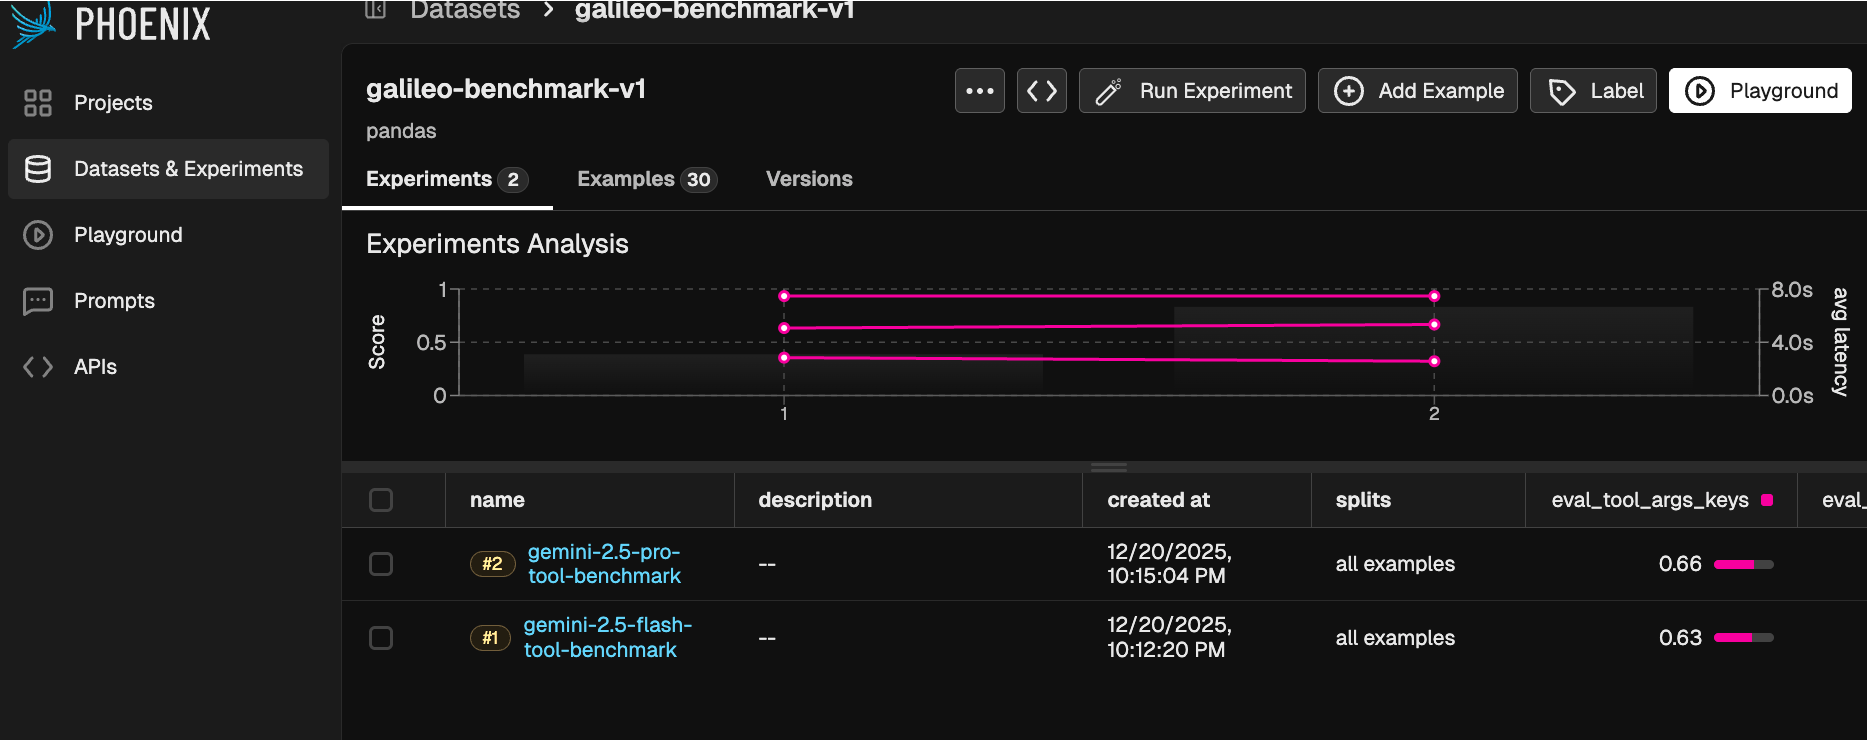


In [ ]:
# Uncomment if you have a local Ollama and you want to benchmark on that.
# print("🧪 Starting Experiment 1: Llama 3.2 (Ollama)...")

## Note: Ensure you have run `ollama pull llama3.2:3b` in your terminal
# Settings.llm = Ollama(model="llama3.2:3b", request_timeout=300.0)

# experiment_llama = run_experiment(
#    dataset=px_dataset,
#    task=run_mcp_agent_task,
#    evaluators=[
#       eval_tool_name,
#        eval_tool_args_keys,
#        eval_tool_args_values
#    ],
#    experiment_name="llama3.2-3b-tool-benchmark",
#    dry_run=False,
#    timeout=120  # Increased timeout to prevent local worker crashes
# )